In [5]:
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
from tqdm import tqdm

In [108]:
sample1 = cv2.imread("./data/ytdataset/images_nopad/training/100_Paul Rice “Waltz for Ella” FREE SHEET MUSIC P Barton FEURICH piano.mp4/0500.png")
sample1 = cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)
sample2 = cv2.imread("./data/MIDItest/images/testing/500_10.mp4/0500.png")
sample2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)
sample3 = cv2.imread("./data/bommelpiano/images/training/600_The Bonnie Banks o Loch Lomond - Piano Arrangement.mp4/0500.png")
sample3 = cv2.cvtColor(sample3, cv2.COLOR_BGR2RGB)

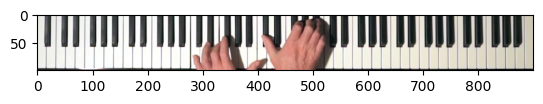

In [109]:
plt.imshow(sample1)

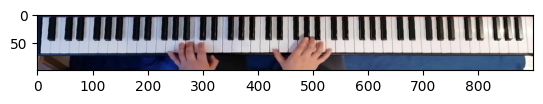

In [110]:
plt.imshow(sample2, cmap="gray")

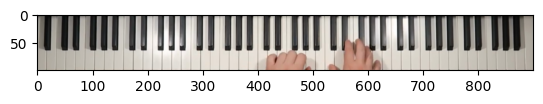

In [111]:
plt.imshow(sample3, cmap="gray")

---------------

In [35]:
label_files = sorted(glob("./data/ytdataset/labels_audeo/training/*"))
label_files_2 = sorted(glob("./data/bommelpiano/labels/training/*"))
label_files_test1 = sorted(glob("./data/ytdataset/labels_audeo/testing/*"))
label_files_test2 = sorted(glob("./data/MIDItest/labels/testing/*"))
label_files_test3 = sorted(glob("./data/bommelpiano/labels/testing/*"))

ds_names = ["yt_train", "bommel_train", "yt_test", "midi_test", "bommel_test"]

In [36]:
check_file_list = [
    label_files, 
    label_files_2, 
    label_files_test1, 
    label_files_test2, 
    label_files_test3]

In [37]:
def make_onset(roll: np.array):
    onset = np.zeros(roll.shape)
    for j in range(roll.shape[0]):
        if j != 0:
            onset[j][np.setdiff1d(roll[j].nonzero(),roll[j - 1].nonzero())] = 1
        else:
            onset[j][roll[j].nonzero()] = 1
    return onset

In [38]:
onset_sum_list = []
for filelist in check_file_list:
    onset_sum = []
    for label in tqdm(filelist):
        label_dict = np.load(label, allow_pickle=True)
        label_np = np.array(list(label_dict.values()))
        label_np = (label_np > 0).astype(int)

        onset_np = make_onset(label_np)

        onset_sum.append(np.sum(onset_np, axis=0))
    onset_sum = np.stack(onset_sum)
    onset_sum_list.append(onset_sum)

100% 182/182 [01:17<00:00,  2.34it/s]
100% 30/30 [00:05<00:00,  5.14it/s]
100% 19/19 [00:07<00:00,  2.56it/s]
100% 8/8 [00:01<00:00,  7.74it/s]
100% 9/9 [00:01<00:00,  4.76it/s]


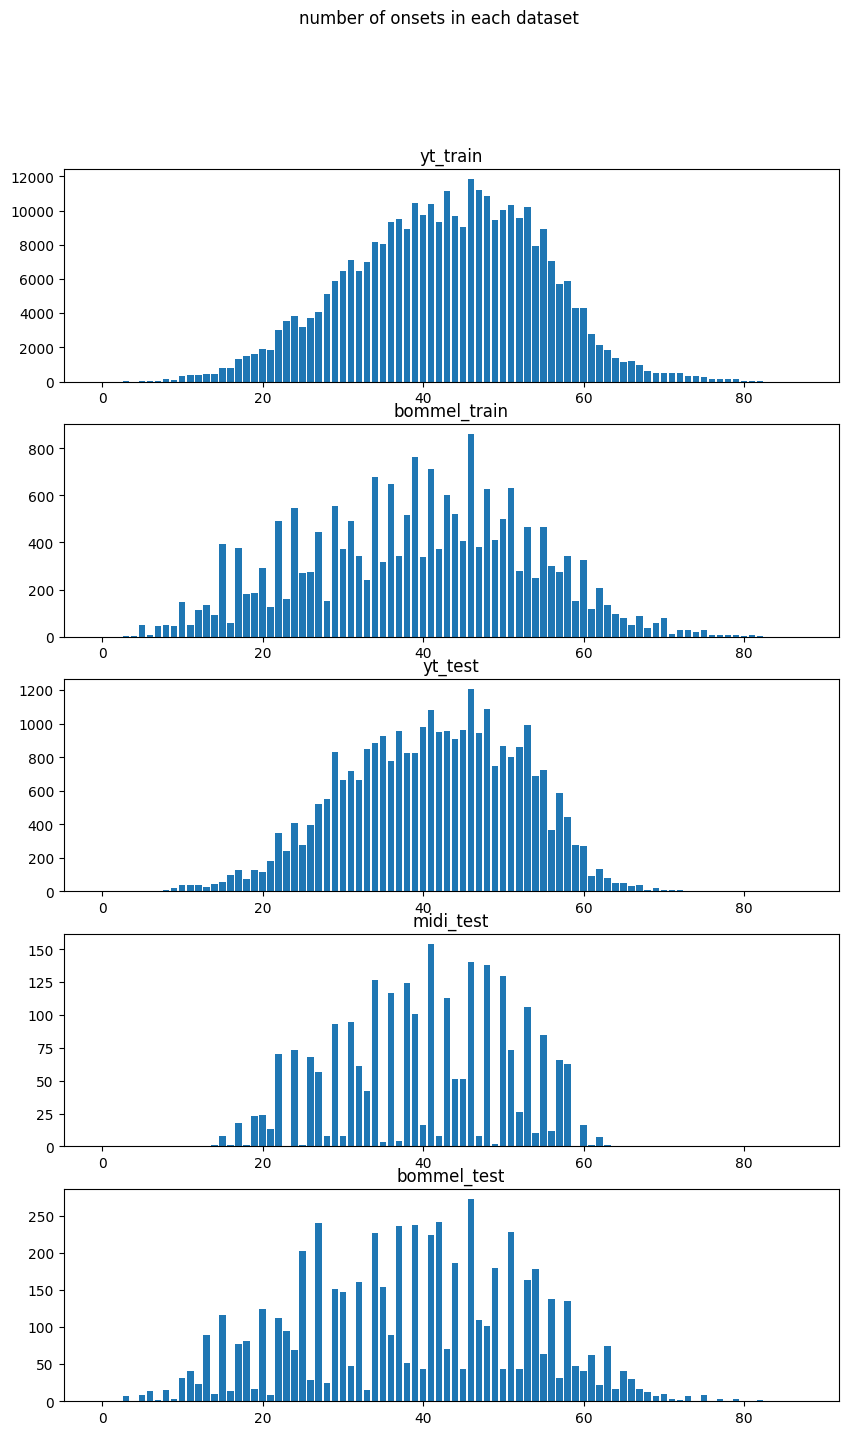

In [64]:
plt.figure(figsize=(10, 16))
plt.suptitle("number of onsets in each dataset")
for i, onset_sum in enumerate(onset_sum_list):
    plt.subplot(5, 1, i+1)
    plt.title(ds_names[i])
    plt.bar(range(88), np.sum(onset_sum, axis=0))

----------

### Get average note length

In [873]:
from collections import defaultdict

def get_note_length_stat(roll: np.array):
    label_np_t = label_np.T
    note_len_stat = defaultdict(int)
    for i in range(len(label_np_t)):
        note_len = 0
        for j in range(len(label_np_t[i])):
            if label_np_t[i][j] == 1:
                note_len += 1
            elif label_np_t[i][j] == 0 and note_len != 0:
                note_len_stat[note_len] += 1
                note_len = 0
    sorted_note_len = sorted(note_len_stat.items(), key=lambda x: x[0])
    return sorted_note_len

def draw_roll(roll: np.array):
    roll = roll.T[::-1]
    print(roll.shape)
    plt.imshow(roll[:, 0:500])

In [875]:
test_paths = sorted(glob("./data/ytdataset/labels_audeo/training/*"))
note_len_mean = {}
plt.figure(figsize=(20, 20))
for i, test_path in enumerate(tqdm(test_paths)):
    filename = test_path.split("/")[-1]
    fileid = filename.split("_")[0]
    label_dict = np.load(test_path, allow_pickle=True)
    label_np = np.array(list(label_dict.values()))
    label_np = (label_np > 0).astype(int)
    
    note_len_stat = np.array(get_note_length_stat(label_np))
    note_len_mean[filename] = (np.sum(note_len_stat[:, 0] * note_len_stat[:, 1]) / sum(note_len_stat[:, 1]))
    
    # plt.title(fileid)
    # plt.subplot(4, 5, i+1)
    # plt.bar(note_len_stat[:, 0], note_len_stat[:, 1])

100% 182/182 [00:51<00:00,  3.54it/s]


<Figure size 2000x2000 with 0 Axes>

In [438]:
song_less_than_25 = []
for song_name, notelen in note_len_mean.items():
    if notelen <=25.0:
        song_less_than_25.append(song_name)

In [442]:
for song_name in song_less_than_25:
    # song_name = ".".join(song_name.split(".")[:-1])
    original_path = os.path.abspath(os.path.join("./data/bommelpiano/labels/training", song_name))
    target_path = os.path.abspath(os.path.join("./data/train_shortpedal/labels/training", song_name))
    os.system(f"ln -s '{original_path}' '{target_path}'")

-------------

### Get onset count

In [140]:
test_paths = sorted(glob("./data/bommelpiano/labels/testing/*"))
onset_count = []
for i, test_path in enumerate(tqdm(test_paths)):
    filename = test_path.split("/")[-1]
    fileid = filename.split("_")[0]
    label_dict = np.load(test_path, allow_pickle=True)
    label_np = np.array(list(label_dict.values()))
    label_np = (label_np > 0).astype(int)
    
    onset_np = make_onset(label_np)
    
    onset_count.append(np.sum(onset_np))

100% 9/9 [00:01<00:00,  4.90it/s]


In [141]:
onset_count

[362.0, 755.0, 482.0, 585.0, 805.0, 1147.0, 506.0, 584.0, 661.0]

-----------

### Get onset gap

In [122]:
def get_onset_gap(onset_roll: np.array):
    onset_gap_stat = defaultdict(int)
    one_line = np.sum(onset_roll, axis=1)
    gap_len = 0
    for onset in one_line:
        if onset > 0 and gap_len == 0:
            gap_len += 1
        elif onset > 0 and gap_len != 0:
            onset_gap_stat[gap_len] += 1
            gap_len = 1
        else:
            gap_len += 1
            
    sorted_onset_gap = sorted(onset_gap_stat.items(), key=lambda x: x[0])
    return sorted_onset_gap
            

  0% 0/9 [00:00<?, ?it/s]/tmp/ipykernel_10694/1028860501.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 5, i+1)
100% 9/9 [00:02<00:00,  3.59it/s]


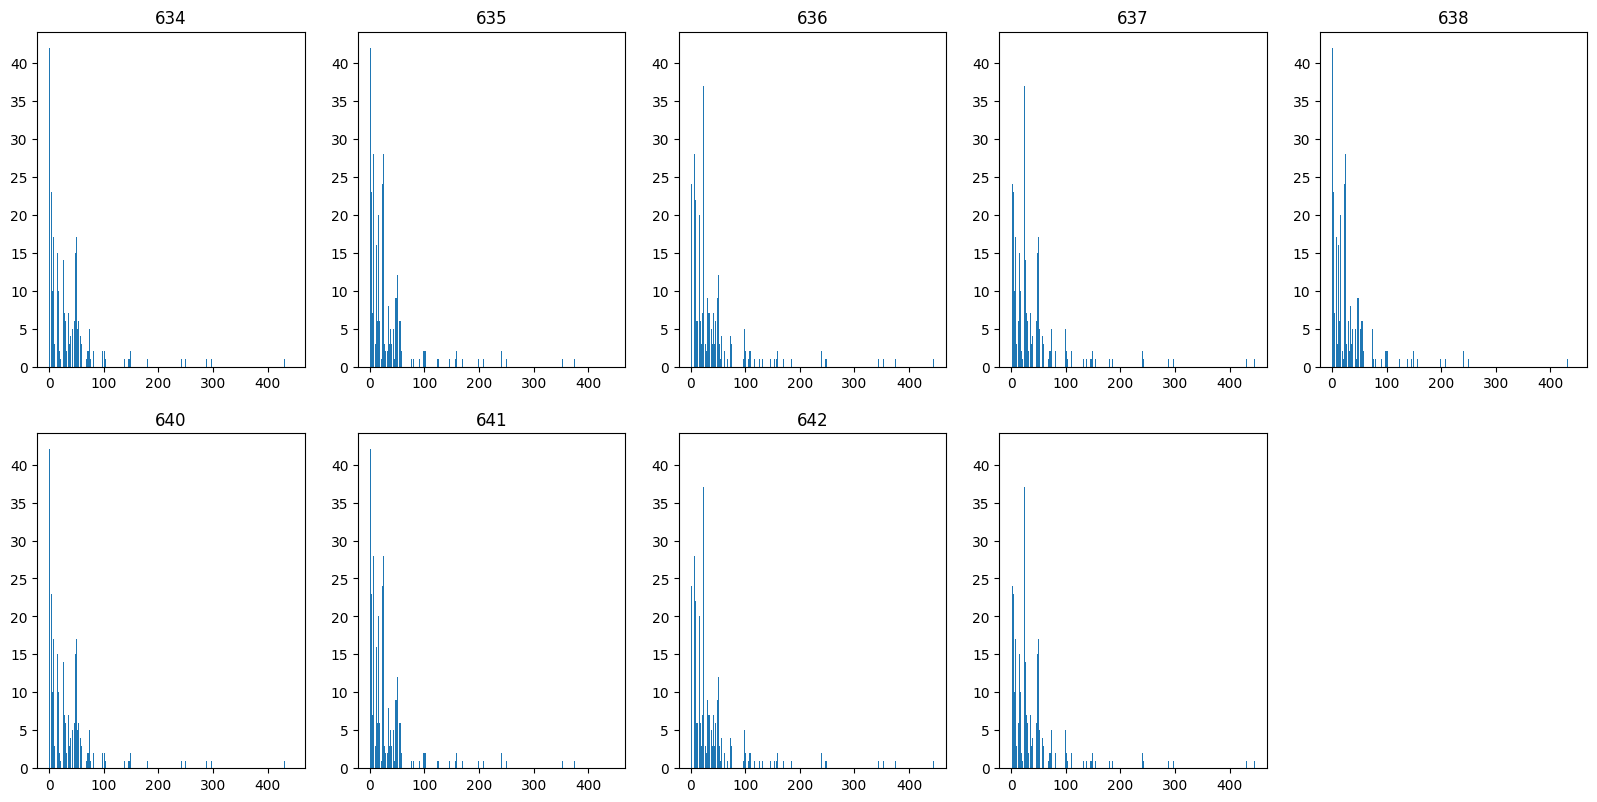

In [142]:
test_paths = sorted(glob("./data/bommelpiano/labels/testing/*"))
gap_mean = []
plt.figure(figsize=(20, 20))
for i, test_path in enumerate(tqdm(test_paths)):
    filename = test_path.split("/")[-1]
    fileid = filename.split("_")[0]
    label_dict = np.load(test_path, allow_pickle=True)
    label_np = np.array(list(label_dict.values()))
    label_np = (label_np > 0).astype(int)
    
    onset_np = make_onset(label_np)
    
    onset_gap = np.array(get_onset_gap(onset_np))
    
    gap_mean.append(np.sum(onset_gap[:, 0] * onset_gap[:, 1]) / sum(onset_gap[:, 1]))
    
    plt.title(fileid)
    plt.subplot(4, 5, i+1)
    plt.bar(note_len_stat[:, 0], note_len_stat[:, 1])

In [143]:
gap_mean

[10.738095238095237,
 7.948863636363637,
 5.358620689655172,
 6.403645833333333,
 6.036559139784946,
 6.9,
 12.250666666666667,
 7.78239608801956,
 9.533333333333333]

### Sampling one frame from videos

In [6]:
data_path = "./data/customdata/videos"
target_path_base = "./comp_images"
images_list = os.listdir(data_path)

In [7]:
sorted(images_list)

['flower_dance.mp4',
 'lark.mp4',
 'lastcarnival.mp4',
 'lostark.mp4',
 'maple-arcana.mp4',
 'maple-asylum.mp4',
 'maple-neocastle.mp4',
 'pianovid.zip',
 'reminiscence.mp4',
 'schubert-impromptu-no4.mp4']

In [9]:
for image_path_base in images_list:
    # image_path_base = sorted(images_list)[50]
    image_path = os.path.join(data_path, image_path_base)
    target_path = os.path.join(target_path_base, image_path_base)
    print(image_path)
    i=0
    cap = cv2.VideoCapture(image_path)
    while True:
        retval, frame = cap.read()
        if not(retval):	# 프레임정보를 정상적으로 읽지 못하면
            break  # while문을 빠져나가기
        i+=1
        # 키 입력을 받으면 키값을 key로 저장 -> esc == 27(아스키코드)
        if i == 1000:
            cv2.imwrite(f'{target_path_base}/{image_path_base}.png', frame)
            break	# while문을 빠져나가기

./data/customdata/videos/reminiscence.mp4
./data/customdata/videos/lastcarnival.mp4
./data/customdata/videos/schubert-impromptu-no4.mp4
./data/customdata/videos/flower_dance.mp4
./data/customdata/videos/pianovid.zip
./data/customdata/videos/maple-arcana.mp4


[ERROR:0@42485.508] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): ./data/customdata/videos/pianovid.zip in function 'icvExtractPattern'




./data/customdata/videos/lark.mp4
./data/customdata/videos/lostark.mp4
./data/customdata/videos/maple-asylum.mp4
./data/customdata/videos/maple-neocastle.mp4


----------

### analog crop

In [10]:
from keyboard_det.crop_preprocess import crop_piano

In [11]:
from glob import glob
import cv2
import matplotlib.pyplot as plt

In [12]:
img_list = sorted(glob("./comp_images/*"))

In [13]:
img_iter = iter(img_list)


0: 384x640 1 piano, 6.7ms
Speed: 3.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


./comp_images/lark.mp4.png
(1080, 1920, 3)
tensor([0.9175], device='cuda:0')
(0, 380, 1913, 612)
minY: 380, maxY: 612, minX: 0, maxX: 1913


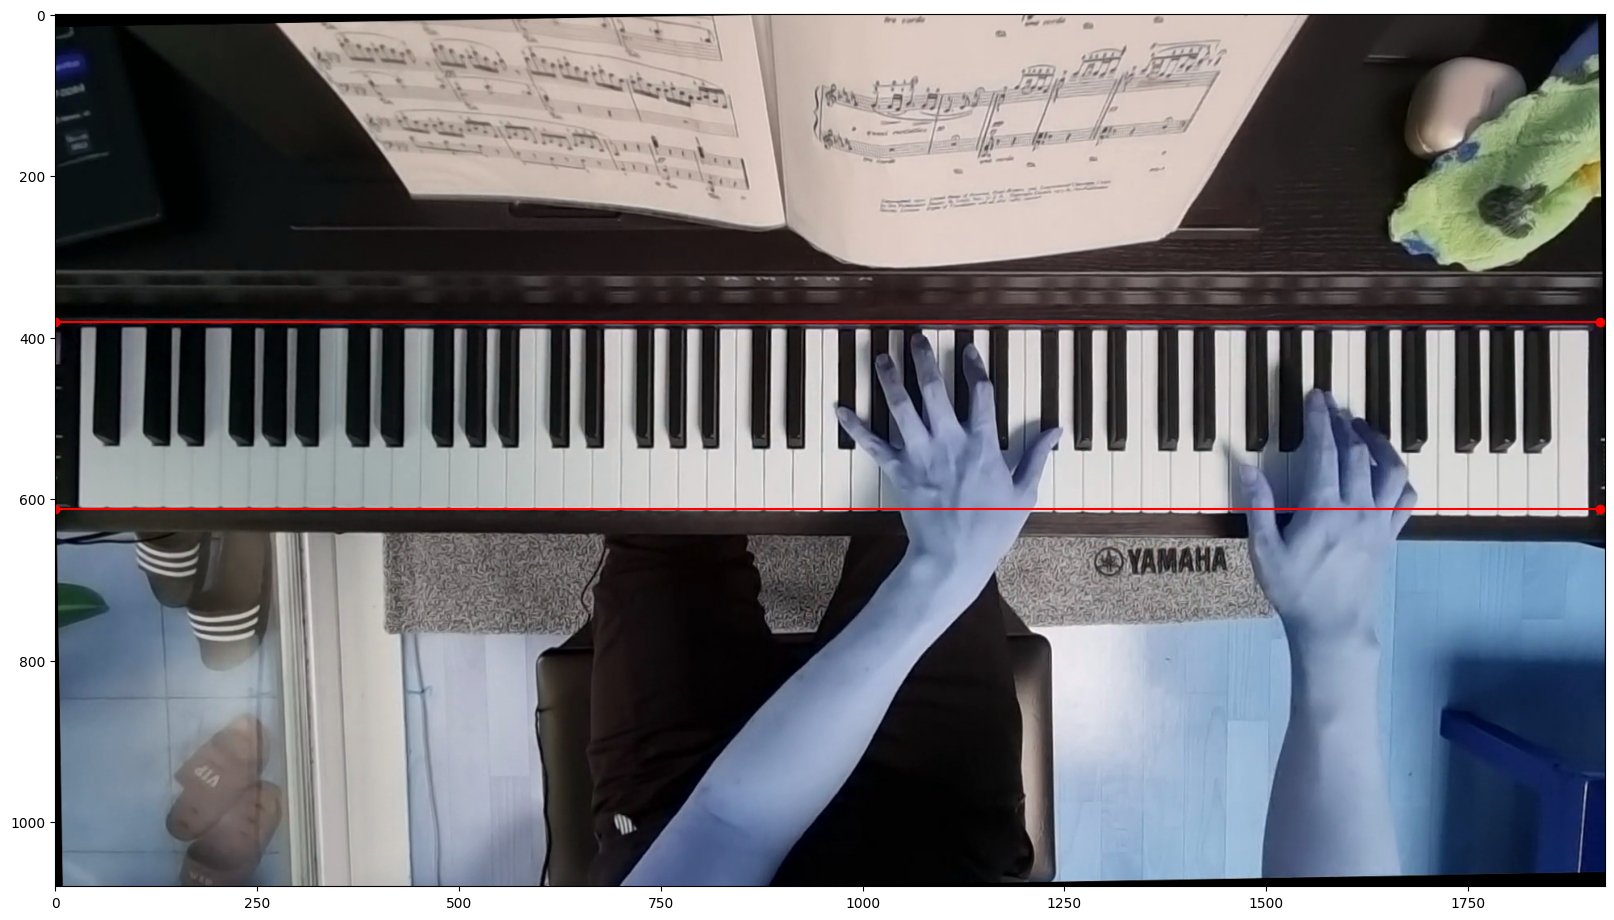

In [29]:
plt.figure(figsize=(20, 15))


img = next(img_iter)
# img = img_list[8]

print(img)
img = cv2.imread(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
points = crop_piano(img)
print(points)
print("minY: {1}, maxY: {3}, minX: {0}, maxX: {2}".format(*points))
plt.imshow(img)
plt.scatter([points[0], points[0], points[2], points[2]], [points[1], points[3], points[1], points[3]], color="red")
plt.plot([points[0], points[2]], [points[1], points[1]], color="red")
plt.plot([points[0], points[2]], [points[3], points[3]], color="red")

In [30]:
points = (22, 384, 1903, 620)

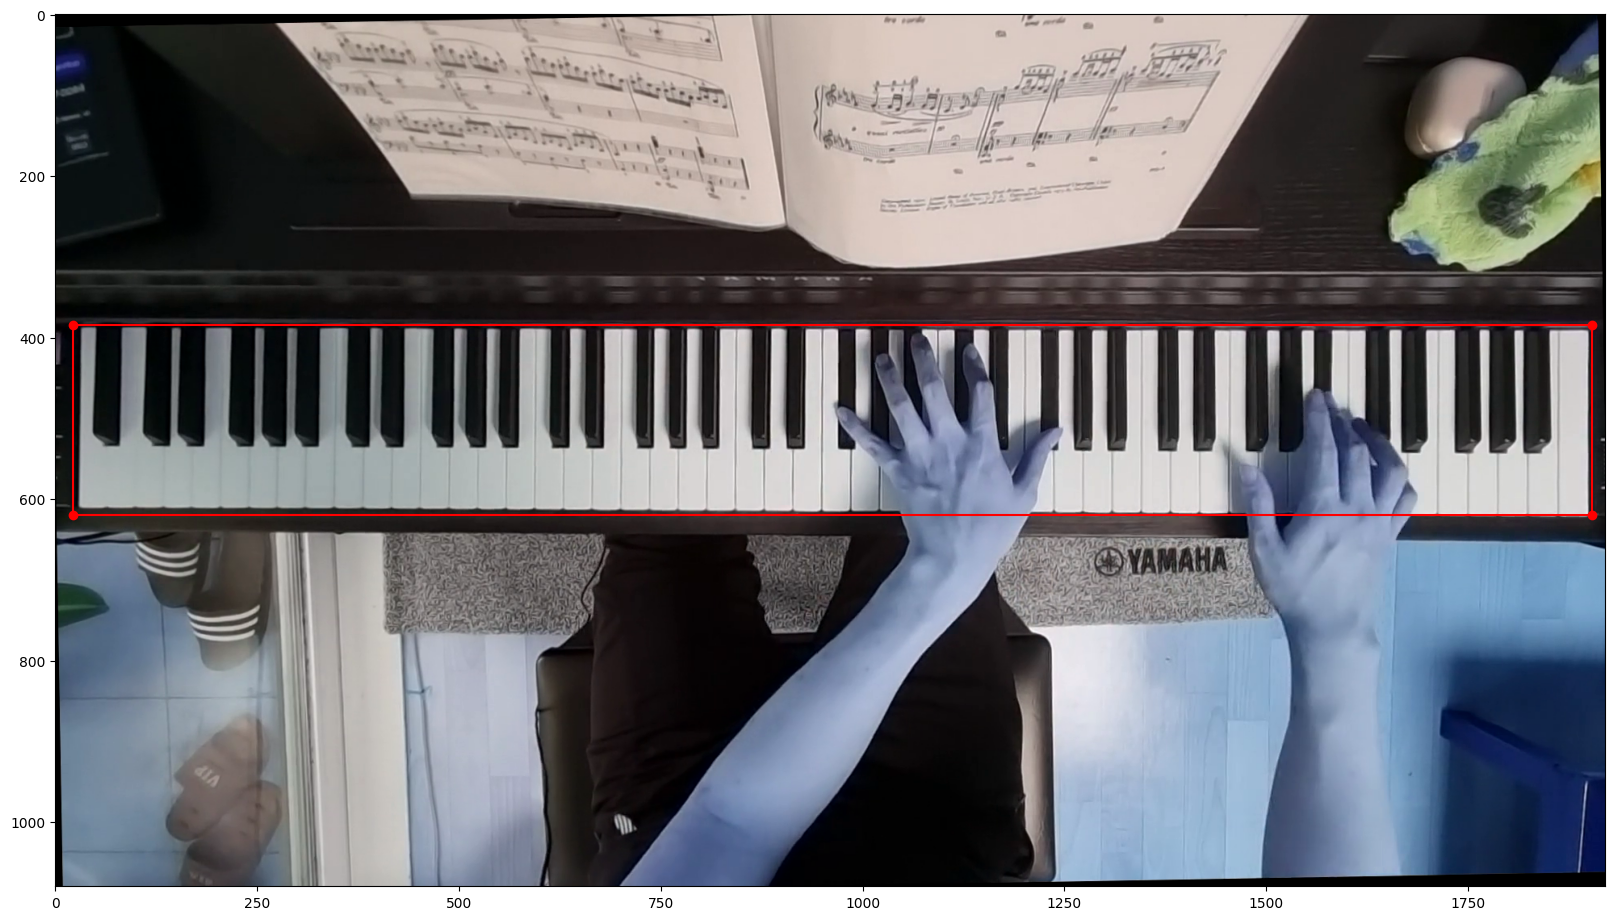

In [31]:
# offset = 36
# print(f"maxYoffset {points[3]-offset}")
# testminY = 393
plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.scatter([points[0], points[0], points[2], points[2]], [points[1], points[3], points[1], points[3]], color="red")
plt.plot([points[0], points[2]], [points[1], points[1]], color="red")
plt.plot([points[0], points[2]], [points[3], points[3]], color="red")
plt.plot([points[0], points[0]], [points[1], points[3]], color="red")
plt.plot([points[2], points[2]], [points[1], points[3]], color="red")
#plt.plot([points[0], points[2]], [testminY, testminY], color="green")
#plt.plot([points[0], points[2]], [points[3]-offset, points[3]-offset], color="red")

In [71]:
import pandas as pd

In [72]:
csv = pd.read_csv("./data/atlantic/atlantic.csv", names=["id", "link", "train/val", "ymin", "ymax", "xmin", "xmax"])

In [73]:
for img in tqdm(img_list):
    img_id = img.split("/")[-1].split("_")[0]
    img = cv2.imread(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        points = crop_piano(img)
        # print("minY: {1}, maxY: {3}, minX: {0}, maxX: {2}".format(*points))
        minY, maxY = points[1], points[3]
        csv.loc[csv['id'] == int(img_id), 'ymin'] = minY
        csv.loc[csv['id'] == int(img_id), 'ymax'] = maxY
    except Exception:
        print(f"failed to find keyboard : {img_id}")

  0% 0/32 [00:00<?, ?it/s]
0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  3% 1/32 [00:00<00:05,  5.91it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  6% 2/32 [00:00<00:04,  7.05it/s]

tensor([0.9405], device='cuda:0')
tensor([0.9208], device='cuda:0')



0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  9% 3/32 [00:00<00:03,  7.44it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 12% 4/32 [00:00<00:03,  7.65it/s]

tensor([0.9301], device='cuda:0')
tensor([0.8795], device='cuda:0')



0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 16% 5/32 [00:00<00:03,  6.83it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 19% 6/32 [00:00<00:03,  7.23it/s]

tensor([0.9188], device='cuda:0')
tensor([0.8578], device='cuda:0')



0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 22% 7/32 [00:00<00:03,  7.50it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 25% 8/32 [00:01<00:03,  7.73it/s]

tensor([0.9542], device='cuda:0')
tensor([0.9182], device='cuda:0')



0: 384x640 1 piano, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
 28% 9/32 [00:01<00:03,  7.55it/s]
0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 31% 10/32 [00:01<00:02,  7.74it/s]

tensor([0.9490], device='cuda:0')
tensor([0.9398], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 34% 11/32 [00:01<00:02,  7.87it/s]
0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 38% 12/32 [00:01<00:02,  7.94it/s]

tensor([0.8789], device='cuda:0')
tensor([0.9316], device='cuda:0')



0: 384x640 1 piano, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 41% 13/32 [00:01<00:02,  7.94it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 44% 14/32 [00:01<00:02,  7.69it/s]

tensor([0.9314], device='cuda:0')
tensor([0.8923], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 47% 15/32 [00:01<00:02,  7.79it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 50% 16/32 [00:02<00:02,  7.12it/s]

tensor([0.9035], device='cuda:0')
tensor([0.9394], device='cuda:0')



0: 384x640 1 piano, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 53% 17/32 [00:02<00:02,  7.39it/s]
0: 384x640 1 piano, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 56% 18/32 [00:02<00:01,  7.36it/s]

tensor([0.9100], device='cuda:0')
tensor([0.9264], device='cuda:0')



0: 384x640 1 piano, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 59% 19/32 [00:02<00:01,  7.57it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 62% 20/32 [00:02<00:01,  7.72it/s]

tensor([0.9147], device='cuda:0')
tensor([0.9289], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 66% 21/32 [00:02<00:01,  7.82it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 69% 22/32 [00:02<00:01,  7.89it/s]

tensor([0.9097], device='cuda:0')
tensor([0.9246], device='cuda:0')



0: 384x640 1 piano, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 72% 23/32 [00:03<00:01,  7.95it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 75% 24/32 [00:03<00:01,  7.97it/s]

tensor([0.9291], device='cuda:0')
tensor([0.8998], device='cuda:0')



0: 384x640 1 piano, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 78% 25/32 [00:03<00:00,  8.01it/s]
0: 384x640 1 piano, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 81% 26/32 [00:03<00:00,  8.03it/s]

tensor([0.9435], device='cuda:0')
tensor([0.9307], device='cuda:0')



0: 384x640 1 piano, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 84% 27/32 [00:03<00:00,  7.66it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 88% 28/32 [00:03<00:00,  7.77it/s]

tensor([0.8812], device='cuda:0')
tensor([0.9454], device='cuda:0')



0: 384x640 1 piano, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 91% 29/32 [00:03<00:00,  7.87it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 94% 30/32 [00:03<00:00,  7.94it/s]

tensor([0.9031], device='cuda:0')
tensor([0.9305], device='cuda:0')



0: 384x640 1 piano, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 97% 31/32 [00:04<00:00,  7.63it/s]
0: 384x640 1 piano, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
100% 32/32 [00:04<00:00,  7.65it/s]

tensor([0.9499], device='cuda:0')
tensor([0.9150], device='cuda:0')


In [74]:
csv

id                            link  train/val  ymin  ymax  xmin  xmax
0     900  'https://youtu.be/yAhtQ3a-urY'          1   600   843     0     0
1     901  'https://youtu.be/MFqIgaqodDk'          1   597   850     0     0
2     902  'https://youtu.be/fFqgsRiouQI'          1   599   850     0     0
3     903  'https://youtu.be/sSmJ54VSO40'          1   598   845     0     0
4     904  'https://youtu.be/AQMCzFlnGhg'          1   599   850     0     0
..    ...                             ...        ...   ...   ...   ...   ...
149  1065  'https://youtu.be/CyRN0GbZ5SY'          3   586   830     0     0
150  1066  'https://youtu.be/gr-I5cbgcnQ'          3   564   803     0     0
151  1067  'https://youtu.be/Urnl9n7Bgio'          3   557   804     0     0
152  1068  'https://youtu.be/qQZGEPo03DU'          3   588   830     0     0
153  1069  'https://youtu.be/-9R7tUfYuIk'          3   564   803     0     0

[154 rows x 7 columns]

In [75]:
csv['xmin'] = [0]*len(csv)
csv['xmax'] = [1920]*len(csv)

In [76]:
csv

id                            link  train/val  ymin  ymax  xmin  xmax
0     900  'https://youtu.be/yAhtQ3a-urY'          1   600   843     0  1920
1     901  'https://youtu.be/MFqIgaqodDk'          1   597   850     0  1920
2     902  'https://youtu.be/fFqgsRiouQI'          1   599   850     0  1920
3     903  'https://youtu.be/sSmJ54VSO40'          1   598   845     0  1920
4     904  'https://youtu.be/AQMCzFlnGhg'          1   599   850     0  1920
..    ...                             ...        ...   ...   ...   ...   ...
149  1065  'https://youtu.be/CyRN0GbZ5SY'          3   586   830     0  1920
150  1066  'https://youtu.be/gr-I5cbgcnQ'          3   564   803     0  1920
151  1067  'https://youtu.be/Urnl9n7Bgio'          3   557   804     0  1920
152  1068  'https://youtu.be/qQZGEPo03DU'          3   588   830     0  1920
153  1069  'https://youtu.be/-9R7tUfYuIk'          3   564   803     0  1920

[154 rows x 7 columns]

In [77]:
csv.to_csv("./data/atlantic/atlantic.csv", header=False, index=False)

-------

### image samples

In [32]:
# image_paths = glob("./data/bommelpiano/images/training/*")
image_paths = glob("./data/customdata/images/*")

In [33]:
image_paths

['./data/customdata/images/1107_lastcarnival.mp4',
 './data/customdata/images/1105_lark.mp4',
 './data/customdata/images/1100_lostark.mp4',
 './data/customdata/images/1108_reminiscence.mp4',
 './data/customdata/images/1102_maple-asylum.mp4',
 './data/customdata/images/1103_maple-arcana.mp4',
 './data/customdata/images/1104_schubert-impromptu-no4.mp4',
 './data/customdata/images/1101_maple-neocastle.mp4',
 './data/customdata/images/1106_flower_dance.mp4']

In [34]:
for i, image_path in enumerate(image_paths):
    img_id = image_path.split('/')[-1].split('_')[0]
    target_load_path = os.path.join(image_path, f'2000.png')
    target_save_path = os.path.join("./comp_images2", f'{img_id}_2000.png')
    os.system(f"cp '{target_load_path}' '{target_save_path}'")

----------

In [703]:
from model import Video2RollNet
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [704]:
model_checkpoint = "./experiments/46_2023-07-16 11:15:27_best_baseline2/Video2Roll_bestf1.pth"
song_name = "117_Pachelbel “Canon in D” (arr T Andersen) P Barton FEURICH piano.mp4"
image_path = os.path.join("./data/ytdataset/images_nopad/training", song_name)
label_path = os.path.join("./data/ytdataset/labels_audeo/training", song_name) + ".pkl"

In [705]:
image_count = len(os.listdir(image_path))

In [706]:
model = Video2RollNet(num_classes=85)
model.to("cuda:1")
model.load_state_dict(torch.load(model_checkpoint, map_location="cuda:1"))

<All keys matched successfully>

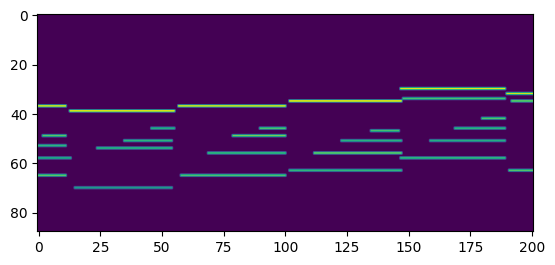

In [707]:
label_dict = np.load(label_path, allow_pickle=True)
label_np = np.stack(label_dict.values())
label_np = label_np.T[::-1]

plt.imshow(label_np[:, 800:1001])

In [708]:
full_img_list = []
for i in range(2, image_count-2):
    image_name_list = [str(i).zfill(4) + ".png" for i in range(i-1, i+4)]
    full_img_list.append(image_name_list)

In [709]:
full_img_list[-1]

['6598.png', '6599.png', '6600.png', '6601.png', '6602.png']

In [710]:
import time

In [711]:
time.time()

1689742402.585279

In [712]:
img_loading_time = 0
img_postprocess_time = 0
img_inference_time = 0

In [713]:
logit_list = []
model.eval()
with torch.no_grad():
    batch = []
    for i, img_list in enumerate(tqdm(full_img_list)):
        img_stack = []
        c = time.time()
        for img in img_list:
            img_path = os.path.join(image_path, img)
            pil_img = Image.open(img_path).convert('L')
            img_stack.append(np.array(pil_img) / 255.)
        img_loading_time += time.time() - c
        
        c = time.time()
        img_stack = torch.from_numpy(np.stack(img_stack)).unsqueeze(dim=0).float()
        batch.append(img_stack)
        img_postprocess_time += time.time() - c

        if len(batch)==50 or i==len(full_img_list)-1:
            c = time.time()
            batch = torch.cat(batch)
            output_test = model(batch.to("cuda:1"))
            output_logit = torch.sigmoid(output_test)
            logit_list.append(output_logit)
            batch = []
            img_inference_time += time.time() - c


# logit_list = []
# model.eval()
# with torch.no_grad():
#     batch = []
#     for i, img_list in enumerate(tqdm(sorted(glob.glob(image_path + "/*"), key=lambda x: int(x.split("/")[-1].split(".")[0])))):
#         img_stack = []

#         c = time.time()
#         while len(img_stack) != 5:
#             pil_img = Image.open(img_list).convert('L')
#             img_stack.append(np.array(pil_img) / 255.)
#         img_loading_time += time.time() - c
        
#         c = time.time()
#         img_stack = torch.from_numpy(np.stack(img_stack)).unsqueeze(dim=0).float()
#         batch.append(img_stack)
#         img_stack = img_stack[1:]
#         img_postprocess_time += time.time() - c
        
#         if len(batch)==50 or i==len(full_img_list)-1:
#             c = time.time()
#             batch = torch.cat(batch)
#             output_test = model(batch.to("cuda:1"))
#             output_logit = torch.sigmoid(output_test)
#             logit_list.append(output_logit)
#             batch = []
#             img_inference_time += time.time() - c
            
            

100% 6598/6598 [01:10<00:00, 94.15it/s] 


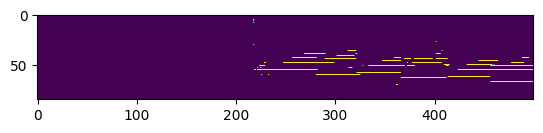

In [716]:
logit_output = torch.cat(logit_list).squeeze().detach().cpu().numpy()
logit_output = logit_output.T[::-1]
plt.imshow(logit_output[:, 0:500]>0.4)

In [717]:
inference_out = "./outputs_single/v2r_output/117_Pachelbel “Canon in D” (arr T Andersen) P Barton FEURICH piano.mp4"

In [718]:
inference_list = glob.glob(inference_out + "/*")
inference_list = sorted(inference_list, key=lambda x: int(x.split("/")[-1].split("-")[0]))

In [719]:
inf_list = []
inf_logit = []
for inf in inference_list:
    inf_load = np.load(inf, allow_pickle=True)
    inf_list.append(inf_load['roll'])
    inf_logit.append(inf_load['logit'])
inf_list = np.concatenate(inf_list)
inf_logit = np.concatenate(inf_logit)

In [720]:
inf_list.shape

(6600, 88)

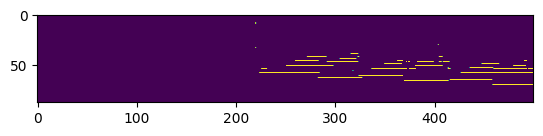

In [721]:
plt.imshow(inf_list.T[::-1][:, 0:500])

In [722]:
roll_output = np.pad((logit_output >= 0.7), ((3, 0), (2, 2)))

In [723]:
label_np = (label_np>0.0).astype(int)
roll_output = roll_output.astype(int)

In [724]:
same = []
diff = []
for i, (roll_line, label_line) in enumerate(zip(roll_output.T, label_np.T)):
    if np.array_equal(roll_line, label_line):
        same.append(i)
    else:
        diff.append(i)

In [725]:
len(same)

2194

In [726]:
len(diff)

4408

In [727]:
idx = np.random.choice(diff, 1)[0]
print(idx)

3739


In [769]:
idx = 1189

In [770]:
def note_convert_to_char(notes):
    NOTE = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    
    return [NOTE[note%12] + str(((note+9) // 12) + 1) for note in notes]

In [771]:
label_notes = np.where(label_np[:, idx:idx+1].T[0][::-1] == 1)[0]
pred_notes = np.where(roll_output[:, idx:idx+1].T[0][::-1] == 1)[0]

In [772]:
label_notes_h = note_convert_to_char(label_notes)
pred_notes_h = note_convert_to_char(pred_notes)

In [773]:
label_notes_h

['D3', 'F#4', 'A4', 'F#5', 'A5']

In [774]:
pred_notes_h

['D3', 'D4', 'F#4', 'A4', 'F#5', 'A5']

In [775]:
full_img_list[idx-2]

['1188.png', '1189.png', '1190.png', '1191.png', '1192.png']

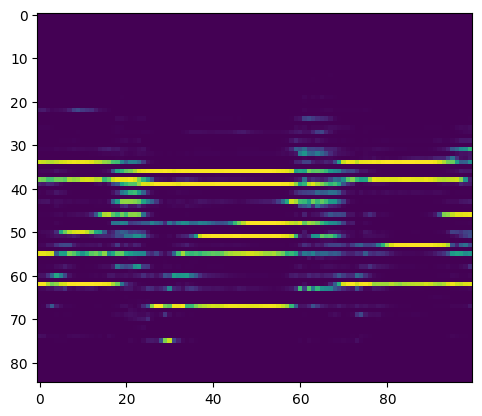

In [776]:
plt.imshow(logit_output[:, idx-50:idx+50])

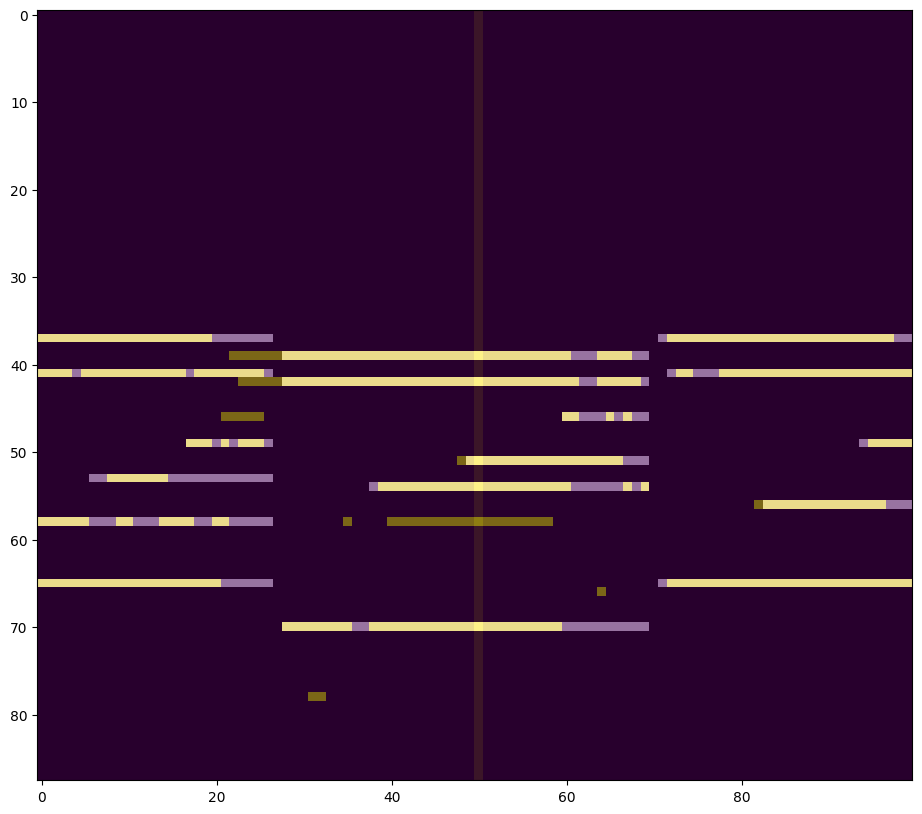

In [777]:
mid_line = np.zeros((88, 100))
mid_line[:, 50] = np.ones(88,)
plt.figure(figsize=(20, 10))
plt.imshow(label_np[:, idx-50:idx+50], cmap="hot")
plt.imshow(roll_output[:, idx-50:idx+50], alpha=0.5)
plt.imshow(mid_line, alpha=0.1)

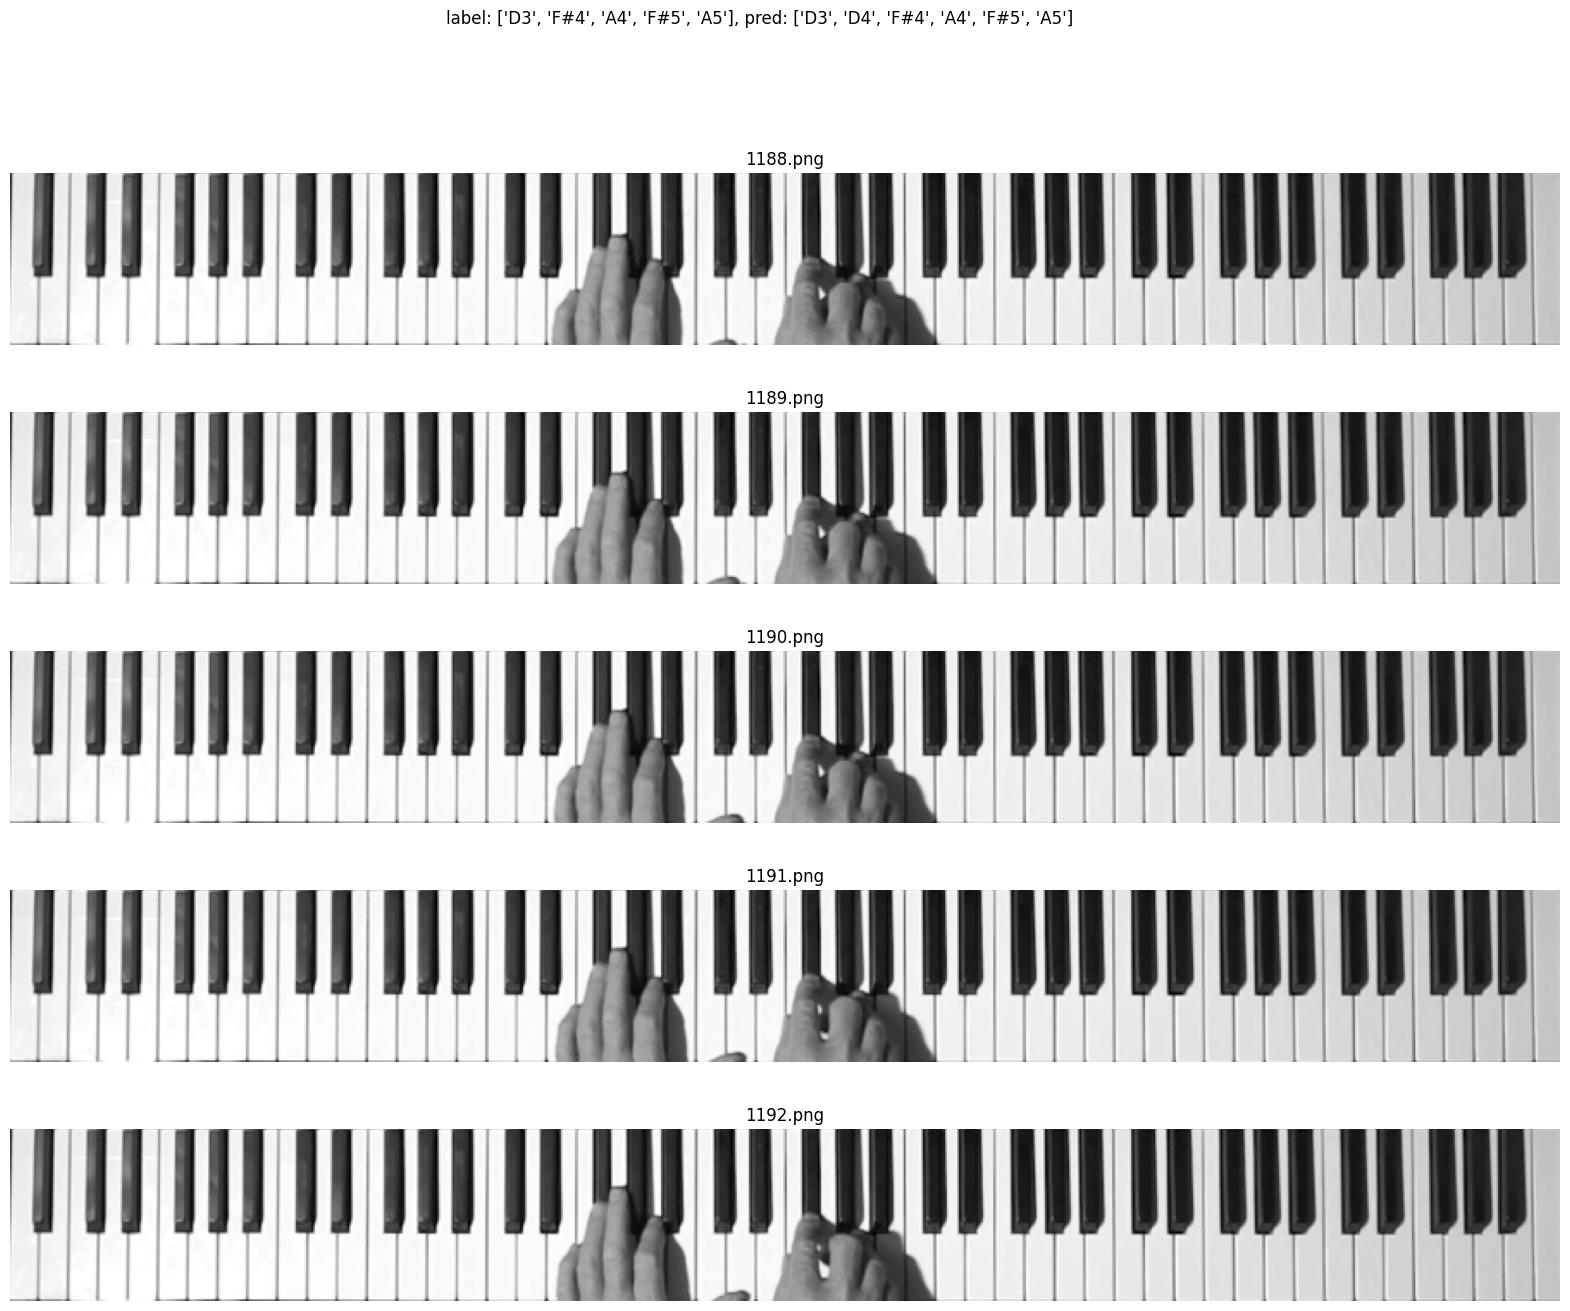

In [778]:
plt.figure(figsize=(20, 15))
plt.suptitle(f"label: {label_notes_h}, pred: {pred_notes_h}")
for i, img in enumerate(full_img_list[idx-2]):
    plt.subplot(5, 1, i+1)
    plt.title(img)
    img = Image.open(os.path.join(image_path, img)).convert('L')
    plt.imshow(img, cmap="gray")
    plt.axis("off")

-------------

In [26]:
from PIL import Image, ImageStat
from glob import glob
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np

In [27]:
im = Image.open("./data/rousseau/images_align/testing/891_Yiruma - River Flows in You/0001.png").convert("L")

In [49]:
br_list = []

for img in sorted(glob("./data/rousseau/images_align/training/811_Beethoven - Moonlight Sonata (3rd Movement)/*.png"), key=lambda x: int(x.split("/")[-1].split(".")[0])):
    im = Image.open(img).convert("L")
    conv_img = transform(image=np.array(im))['image']
    conv_img = Image.fromarray(conv_img)
    br_list.append(ImageStat.Stat(conv_img).mean[0])

x = list(range(0, len(br_list)))

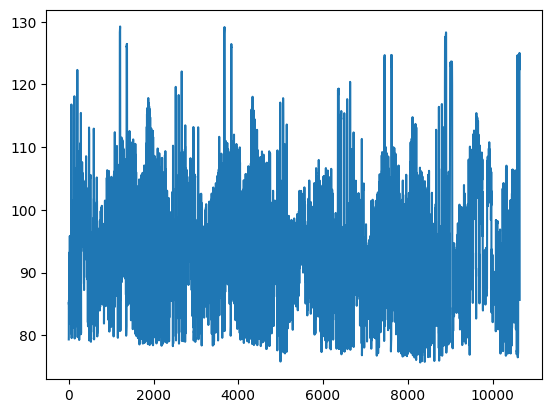

In [50]:
plt.plot(x, br_list)

In [35]:
imtest = Image.open("./data/kassia/images/testing/777_Mozart - Fantasia in d minor K397.mp4/1000.png").convert("L")

/opt/conda/envs/vmt/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


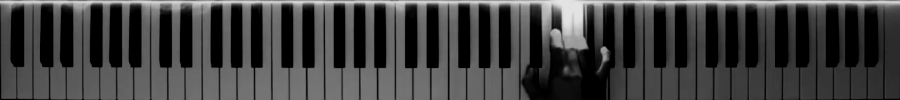

In [49]:
Image.fromarray(transform(image=np.array(imtest))['image'])

In [39]:
br_list2 = []

for img in sorted(glob("./data/kassia/images/testing/777_Mozart - Fantasia in d minor K397.mp4/*.png"), key=lambda x: int(x.split("/")[-1].split(".")[0])):
    im = Image.open(img).convert("L")
    br_list2.append(ImageStat.Stat(im).mean[0])

x2 = list(range(0, len(br_list2)))

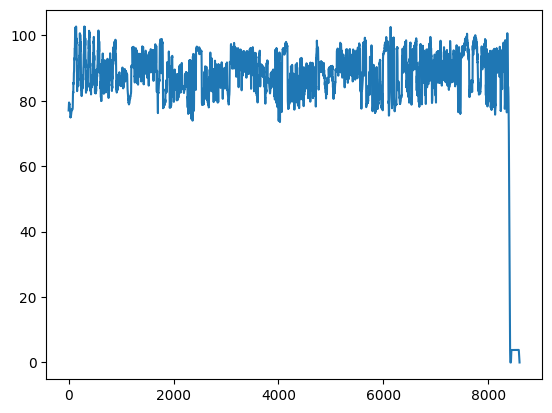

In [41]:
plt.plot(x2, br_list2)

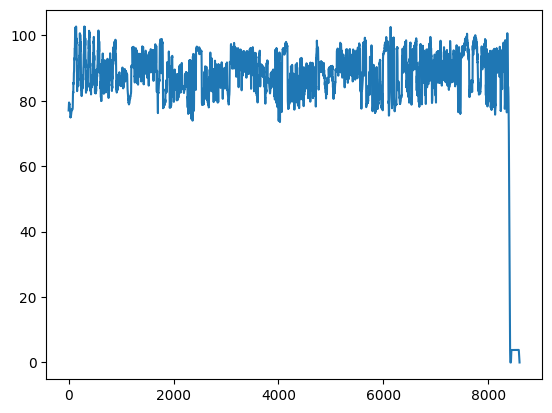

In [32]:
plt.plot(x2, br_list2)

In [11]:
ImageStat.Stat(im).mean[0]

58.867777777777775

In [1]:
from dataset import Video2RollDataset
from PIL import Image, ImageStat
from glob import glob
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
from albumentations.core.transforms_interface import ImageOnlyTransform
import torch

In [2]:
from dataset.augmentation import BaseAugmentation, RandBrightness, CropHalfTop, Normalize, EraseHalfTop

In [3]:
transform = CropHalfTop(p=0.5)

AttributeError: 'int' object has no attribute 'shape'

In [ ]:
ds = Video2RollDataset("./data/rousseau/images_align/", "./data/rousseau/labels_align/", transform, "test")

In [ ]:
ds_sample = ds[91550][0]
plt.figure(figsize=(20, 15))
plt.subplot(5, 1, 1)
plt.imshow(ds_sample[0], cmap="gray")
plt.subplot(5, 1, 2)
plt.imshow(ds_sample[1], cmap="gray")
plt.subplot(5, 1, 3)
plt.imshow(ds_sample[2], cmap="gray")
plt.subplot(5, 1, 4)
plt.imshow(ds_sample[3], cmap="gray")
plt.subplot(5, 1, 5)
plt.imshow(ds_sample[4], cmap="gray")

{'cols': 900, 'rows': 100}
{'cols': 900, 'rows': 100}
{'cols': 900, 'rows': 100}
{'cols': 900, 'rows': 100}
{'cols': 900, 'rows': 100}
[(100, 900), (100, 900), (100, 900), (100, 900), (100, 900)]


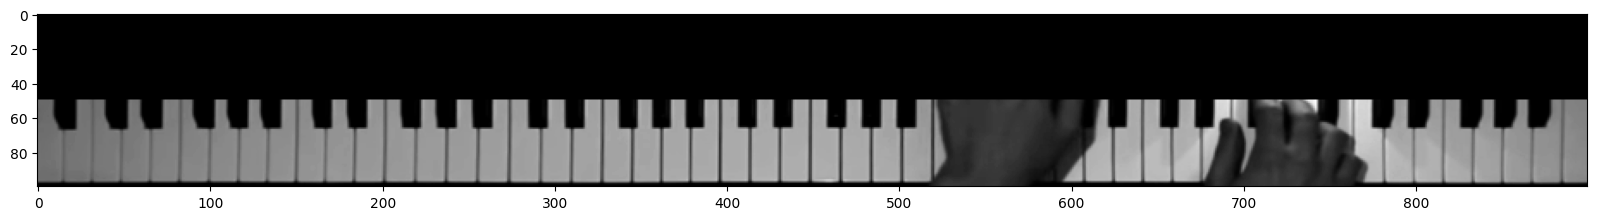

In [6]:
plt.figure(figsize=(20, 8))
plt.imshow(ds[40010][0][0], cmap="gray")

In [50]:
from mido import MidiFile